<a href="https://colab.research.google.com/github/jyotiraj-code/dissertation/blob/main/Expectation_Value_Qiskit_and_Quimb_(Working).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install qiskit --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 5.8 MB/s eta 0:00:00


In [3]:
!pip install qiskit_aer --quiet
!pip install qiskit_ibm_runtime --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.3/343.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.4/121.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 3.7 MB/s eta 0:00:00


#Generate the num_qubits and the random_state

In [5]:
import random

def generate_qubits_number():
    return random.choice([i for i in range(1,15) if i % 2 == 0])

num_qubits = generate_qubits_number()
print(f"The generated even number is: {num_qubits}")


The generated even number is: 8


In [6]:
def generate_random_binary(length):
    return ''.join(random.choice(['0', '1']) for _ in range(length))

state_length = num_qubits
random_state = generate_random_binary(state_length)
print(f"The generated random state is: {random_state}")
print()


The generated random state is: 01001010



# Qiskit

### Doing the QFT for the range of all the qubits

In [7]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import Aer
from math import pi

In [8]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)


def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

def qft_rotations_reverse(circuit, n):
    """Performs qft on the first n qubits in reverse order (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    # Apply controlled phase gates first in reverse order
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # Apply the Hadamard gate after the controlled phase gates
    circuit.h(n)
    # Call the function recursively on the next qubits
    qft_rotations_reverse(circuit, n)

def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft_reverse(circuit, n):
    """QFT on the first n qubits in reverse order"""
    qft_rotations_reverse(circuit, n)
    swap_registers(circuit, n)
    return circuit


### Getting State, Encoding, Applying Direct QFT, define Estimators and transpile conditions, doing expectation value calculation

In [81]:
from qiskit.circuit.library import QFT
# Number of qubits and the initial state
qubit_no = num_qubits  # This can be changed based on tensor network results
state = random_state

# Create the quantum circuit
qc = QuantumCircuit(qubit_no)

# Apply the X gate where the state has '1'
for i, number in enumerate(state):
    if number == '1':
        qc.x(i)
# print(qc.draw())


#APPLY QFT (TO CHECK AGAIN THIS PORTION)
qft(qc, qubit_no)
# print(qc.draw())

## The Estimators (Currently Not Working)

In [34]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

# Run the sampler job locally using FakeManilaV2
fake_manila = FakeManilaV2()

# You can use a fixed seed to get fixed results.
options = {"simulator": {"seed_simulator": 42}}

# Define Estimator
estimator = Estimator(mode=fake_manila, options=options)

Checking the expectation value regarding the circuit

In [66]:
from qiskit.quantum_info.operators import Operator, Pauli, SparsePauliOp
op = Pauli("ZZ"*)
job = estimator.run([(qc, op)])
result = job.result()
print(result)

IBMInputValueError: 'The circuit has 8 qubits but the target system requires 5 qubits. Circuits that do not match the target hardware definition are no longer supported after March 4, 2024. See the transpilation documentation (https://docs.quantum.ibm.com/guides/transpile) for instructions to transform circuits and the primitive examples (https://docs.quantum.ibm.com/guides/primitives-examples) to see this coupled with operator transformations.'

In [ ]:
SparsePauliOp(["ZZ"])
print()

## Not deprecated Estimator method

In [96]:
import numpy as np
from qiskit.circuit.library import IQP
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp, random_hermitian
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator


from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

import numpy as np
from qiskit.quantum_info import SparsePauliOp

matrix = np.array([[1.67757815e-05+0.j, 0.00000000e+00+0.j, 0.00000000e+00+0.j,
        0.00000000e+00+0.j],
       [0.00000000e+00+0.j, 5.96097415e+04+0.j, 0.00000000e+00+0.j,
        0.00000000e+00+0.j],
       [0.00000000e+00+0.j, 0.00000000e+00+0.j, 5.96097415e+04+0.j,
        0.00000000e+00+0.j],
       [0.00000000e+00+0.j, 0.00000000e+00+0.j, 0.00000000e+00+0.j,
        1.67757815e-05+0.j]])

observable = SparsePauliOp.from_operator(matrix)
print(observable)

backend = FakeManilaV2()
options = {"simulator": {"seed_simulator": 42}}
estimator = Estimator(mode=fake_manila, options=options)


job = estimator.run([(qc, observable)])
result = job.result()
print(result)

SparsePauliOp(['I', 'Z'],
              coeffs=[ 29804.87075839+0.j, -29804.87074161+0.j])


TypeError: object of type 'int' has no len()

Doing some debugging stuff (can delete later)

In [10]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp
num_qubits = 8
random_state = '11101001'

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
# Number of qubits and the initial state
qubit_no = num_qubits  # This can be changed based on tensor network results
state = random_state

# Create the quantum circuit
qc = QuantumCircuit(qubit_no)

# Apply the X gate where the state has '1'
for i, number in enumerate(state):
    if number == '1':
        qc.x(i)
# print(qc.draw())


#APPLY QFT (TO CHECK AGAIN THIS PORTION)
qft(qc, qubit_no)
# print(qc.draw())

matrix = np.array([[1.67757815e-05+0.j, 0.00000000e+00+0.j, 0.00000000e+00+0.j,
        0.00000000e+00+0.j],
       [0.00000000e+00+0.j, 5.96097415e+04+0.j, 0.00000000e+00+0.j,
        0.00000000e+00+0.j],
       [0.00000000e+00+0.j, 0.00000000e+00+0.j, 5.96097415e+04+0.j,
        0.00000000e+00+0.j],
       [0.00000000e+00+0.j, 0.00000000e+00+0.j, 0.00000000e+00+0.j,
        1.67757815e-05+0.j]])


observable = SparsePauliOp(['ZZ'], coeffs=[-29804.87074161+0.j])
# observable = SparsePauliOp.from_operator(matrix)
# print(observable)

from qiskit.primitives import Estimator
estimator = Estimator()

expectation_value = estimator.run(qc, observable).result().values[0]
print(expectation_value)


<ipython-input-10-c32ed370888c>:40: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


ValueError: The number of qubits of the 0-th circuit (8) does not match the number of qubits of the 0-th observable (2).

In [40]:
from math import exp, pi
from qiskit.quantum_info.operators import Operator
theta = pi/4
ZZ = Operator(
    np.array(
        [
                [exp(-i*theta), 0, 0, 0],
                [0, exp(i*theta), 0, 0],
                [0, 0, exp(i*theta), 0],
                [0, 0, 0, exp(-i*theta)],
            ]
    )
)
ZZ.data


array([[ 0.09478022+0.j,  0.        +0.j,  0.        +0.j,
         0.        +0.j],
       [ 0.        +0.j, 10.55072407+0.j,  0.        +0.j,
         0.        +0.j],
       [ 0.        +0.j,  0.        +0.j, 10.55072407+0.j,
         0.        +0.j],
       [ 0.        +0.j,  0.        +0.j,  0.        +0.j,
         0.09478022+0.j]])

In [1]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp

matrix = np.array([[ 0.09478022+0.j,  0.        +0.j,  0.        +0.j,
         0.        +0.j],
       [ 0.        +0.j, 10.55072407+0.j,  0.        +0.j,
         0.        +0.j],
       [ 0.        +0.j,  0.        +0.j, 10.55072407+0.j,
         0.        +0.j],
       [ 0.        +0.j,  0.        +0.j,  0.        +0.j,
         0.09478022+0.j]])

observable = SparsePauliOp.from_operator(matrix)
print(observable)

SparsePauliOp(['II', 'ZZ'],
              coeffs=[ 5.32275214+0.j, -5.22797192+0.j])


In [9]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
import numpy as np
from math import pi


#Defining the oeprator in the matrix form
# matrix = np.array([[ 0.09478022+0.j,  0.        +0.j,  0.        +0.j,
#          0.        +0.j],
#        [ 0.        +0.j, 10.55072407+0.j,  0.        +0.j,
#          0.        +0.j],
#        [ 0.        +0.j,  0.        +0.j, 10.55072407+0.j,
#          0.        +0.j],
#        [ 0.        +0.j,  0.        +0.j,  0.        +0.j,
#          0.09478022+0.j]])
# op = SparsePauliOp.from_operator(matrix)
# print(op)
# Step 1: Define operator
op = SparsePauliOp.from_list(
    [
        ("ZZ"*i, -5.22797192+0.j),
    ]
)

# Step 2: Define quantum state

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
# Number of qubits and the initial state
qubit_no = num_qubits  # This can be changed based on tensor network results
state = random_state

# Create the quantum circuit
qc = QuantumCircuit(qubit_no)

# Apply the X gate where the state has '1'
for i, number in enumerate(state):
    if number == '1':
        qc.x(i)
# print(qc.draw())


#APPLY QFT (TO CHECK AGAIN THIS PORTION)
qft(qc, qubit_no)


# Define a local backend
from qiskit_ibm_runtime.fake_provider import FakeOsaka
backend = FakeOsaka()

# Or define a real backend
# from qiskit_ibm_runtime import QiskitRuntimeService
# service = QiskitRuntimeService()
# backend = service.least_busy(operational=True, simulator=False)

# Circuits and parameters must obey the Instruction Set Architecture (ISA) of a particular backend.
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)

isa_observable = op.apply_layout(isa_circuit.layout)

from qiskit_ibm_runtime import EstimatorV2 as Estimator

estimator = Estimator(backend, options={"default_shots": int(1e4)})
job = estimator.run([(isa_circuit, isa_observable)])



# Get results for the first (and only) PUB
pub_result = job.result()[0]

print(f">>> Expectation value: {pub_result.data.evs}")

>>> Expectation value: -0.037641397824


# Quimb

In [9]:
#Imports and Installations

!pip install -U git+https://github.com/jcmgray/quimb.git --quiet

%config InlineBackend.figure_formats = ['svg']
import quimb as qu
import quimb.tensor as qtn
import numpy as np
from math import pi


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.8/177.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


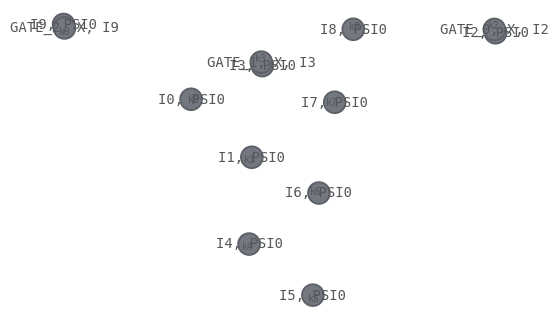

100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


[{'tn': TensorNetwork(tensors=1, indices=0),
  'tree': <ContractionTree(N=1)>,
  'W': 1,
  'C': 0.0},
 {'tn': TensorNetwork(tensors=10, indices=6),
  'tree': <ContractionTree(N=10)>,
  'W': 3.0,
  'C': 1.9637878273455553},
 {'tn': TensorNetwork(tensors=1, indices=0),
  'tree': <ContractionTree(N=1)>,
  'W': 1,
  'C': 0.0},
 {'tn': TensorNetwork(tensors=1, indices=0),
  'tree': <ContractionTree(N=1)>,
  'W': 1,
  'C': 0.0},
 {'tn': TensorNetwork(tensors=1, indices=0),
  'tree': <ContractionTree(N=1)>,
  'W': 1,
  'C': 0.0}]

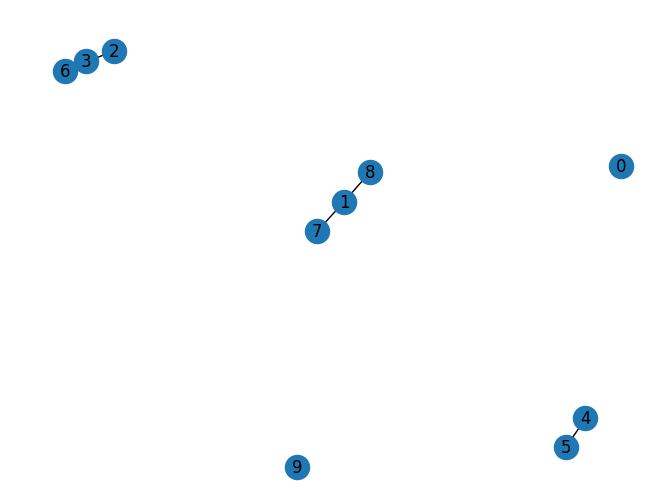

In [20]:
# def qft_rotations(circuit, qubits):
#     for i in range(len(qubits)):
#         circuit.apply_gate('H', qubits[i], 'contract', False)
#         for j in range(i+1, len(qubits)):
#             lamda = np.pi / 2**(j - i)
#             circuit.apply_gate('CPHASE', lamda, qubits[i], qubits[j])

from quimb.tensor.circuit import Circuit
#Encoding the states

#First let us create the circuit so that we can store the states in their particular order
qc = qtn.Circuit(num_qubits)
#Getting the registers
regs = list(range(num_qubits))
#Encoding the values
for i, number in enumerate(random_state):
  if number =='1':
    qc.apply_gate('X', regs[i])
# print(regs)

qc.psi.draw()
# Drawing the circuit
# qc.psi.to_dense()
depth = 1




def circ_qft(num_qubits, random_state, depth,
    **circuit_opts,
):

    circuit_opts.setdefault('gate_opts', {})
    circuit_opts['gate_opts'].setdefault('contract', False)

    n = num_qubits
    gates = []
    qubits=np.arange(n)
    for i, number in enumerate(random_state):
            gates.append(('X', qubits[i]))

    #QFT
    for d in range(depth):
        for i in range(num_qubits):
            gates.append((d, 'h', i)) #H gate
            for j in range(i+1, num_qubits):
                lamda = np.pi / 2**(j - i)
                gates.append((d, 'CPHASE', lamda, qubits[i], qubits[j]))#Cphase

            for i in range(num_qubits//2):
                gates.append((d, 'CNOT', qubits[i], qubits[len(qubits)-i-1]))
                gates.append((d, 'CNOT', qubits[len(qubits)-i-1], qubits[i]))
                gates.append((d, 'CNOT', qubits[i], qubits[len(qubits)-i-1]))





    circ = Circuit(n, **circuit_opts)
    circ.apply_gates(gates)


    return circ

qubits=np.arange(num_qubits)
# for i in range(num_qubits//2):
#    print(i, len(qubits)-i-1)


qc= circ_qft(num_qubits, random_state, depth)

import networkx as nx
import random

# Define the number of nodes
num_nodes = num_qubits

# Calculate the number of edges based on the 2:1 node-to-edge ratio
num_edges = num_nodes // 2

# Create an empty graph
G = nx.Graph(seed = '666')
# nx.draw(G)

# Add nodes to the graph
G.add_nodes_from(range(num_nodes))

# Randomly add edges until the desired number of edges is reached
while G.number_of_edges() < num_edges:
    # Pick two random nodes to connect with an edge
    u, v = random.sample(range(num_nodes), 2)
    # Add the edge if it doesn't already exist
    if not G.has_edge(u, v):
        G.add_edge(u, v)


reg = 3
n = num_qubits
seed = 666
F = nx.random_regular_graph(reg, n, seed=seed)

terms = {(i, j): 1 for i, j in F.edges}
#nx.draw(F, with_labels = True)
# Draw the graph
nx.draw(G, with_labels=True)
# display(nx.edges(G))
G.edges()

import cotengra as ctg
import tqdm

opt = ctg.ReusableHyperOptimizer(
    methods=['greedy'],
    reconf_opts={},
    max_repeats=32,
    max_time="rate:1e6",
    parallel=True,
    # use the following for persistently cached paths
    # directory=True,
)
# edge=(0,2)

terms = {(i, j): 1 for i, j in G.edges}
theta = np.pi/4

RZZ =qu.pauli('Z') & qu.pauli('Z')

local_exp_rehs = [qc.local_expectation_rehearse(ZZ, edge, optimize=opt) for edge, weight in tqdm.tqdm(list(terms.items()))]

local_exp_rehs

In [21]:
local_exp_rehs = [qc.local_expectation(weight * ZZ, edge, optimize=opt) for edge, weight in tqdm.tqdm(list(terms.items()))]

100%|██████████| 5/5 [00:00<00:00, 163.80it/s]


In [22]:
sum(local_exp_rehs)

(-0.744250952773529-3.095195308882206e-17j)

# Theoretical data and the comparision (Problematic and Giving Errors)

The generated random state is: 110011

>>> Expectation value from qiskit: 0.072146012496


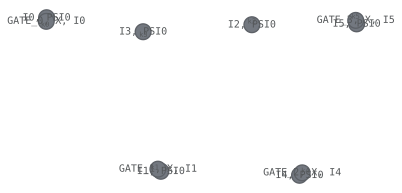

100%|██████████| 3/3 [00:00<00:00, 476.30it/s]


>>> Expectation value from qiskit: 0.072146012496

>>> Expectation value from quimb: (4.438665592473617+1.249000902703301e-16j)

The generated random state is: 01011111

>>> Expectation value from qiskit: -0.10978741032


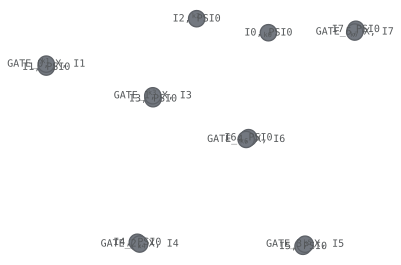

  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/cotengra/hyperoptimizers/hyper.py:54: UserWarning: Couldn't find `optuna`, `baytune (btb)`, `chocolate`, `nevergrad` or `skopt` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
100%|██████████| 4/4 [00:00<00:00, 146.58it/s]


>>> Expectation value from qiskit: -0.10978741032

>>> Expectation value from quimb: (-0.5858728270950246+1.0681597275151434e-15j)

The generated random state is: 1010000101

>>> Expectation value from qiskit: 0.060644474271999996


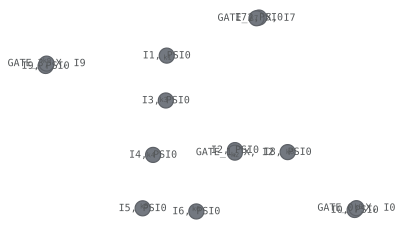

100%|██████████| 5/5 [00:00<00:00, 162.29it/s]
/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


>>> Expectation value from qiskit: 0.060644474271999996

>>> Expectation value from quimb: (-3.936095628053532+1.0790593165714205e-15j)



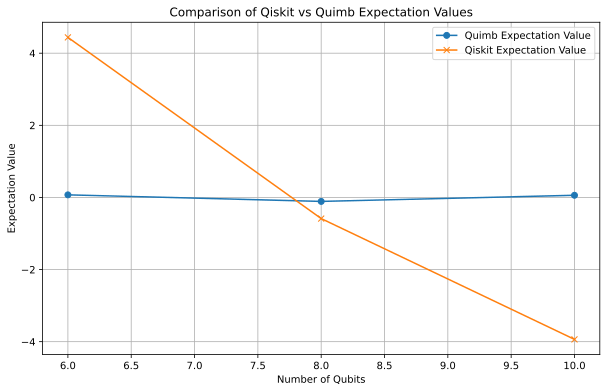

In [13]:

import matplotlib.pyplot as plt

qiskit_expectation_values = []
quimb_expectation_values = []
qubits_range = list(range(6, 12, 2))
theta = pi/4


for num_qubits in range(6,12,2):
    def generate_random_binary(length):
      return ''.join(random.choice(['0', '1']) for _ in range(length))

    state_length = num_qubits
    random_state = generate_random_binary(state_length)
    print(f"The generated random state is: {random_state}")
    print()

    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(pi/2**(n-qubit), qubit, n)
        # At the end of our function, we call the same function again on
        # the next qubits (we reduced n by one earlier in the function)
        qft_rotations(circuit, n)


    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit

    def qft(circuit, n):
        """QFT on the first n qubits in circuit"""
        qft_rotations(circuit, n)
        swap_registers(circuit, n)
        return circuit

    def qft_rotations_reverse(circuit, n):
        """Performs qft on the first n qubits in reverse order (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        # Apply controlled phase gates first in reverse order
        for qubit in range(n):
            circuit.cp(pi/2**(n-qubit), qubit, n)
        # Apply the Hadamard gate after the controlled phase gates
        circuit.h(n)
        # Call the function recursively on the next qubits
        qft_rotations_reverse(circuit, n)

    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit

    def qft_reverse(circuit, n):
        """QFT on the first n qubits in reverse order"""
        qft_rotations_reverse(circuit, n)
        swap_registers(circuit, n)
        return circuit

    from qiskit import QuantumCircuit
    from qiskit.quantum_info import SparsePauliOp
    import numpy as np
    from math import pi


    #Defining the oeprator in the matrix form
    # matrix = np.array([[ 0.09478022+0.j,  0.        +0.j,  0.        +0.j,
    #          0.        +0.j],
    #        [ 0.        +0.j, 10.55072407+0.j,  0.        +0.j,
    #          0.        +0.j],
    #        [ 0.        +0.j,  0.        +0.j, 10.55072407+0.j,
    #          0.        +0.j],
    #        [ 0.        +0.j,  0.        +0.j,  0.        +0.j,
    #          0.09478022+0.j]])
    # op = SparsePauliOp.from_operator(matrix)
    # print(op)
    # Step 1: Define operator
    op = SparsePauliOp.from_list(
        [
            ("ZZ"*int(num_qubits/2), -5.22797192+0.j),
        ]
    )

    # Step 2: Define quantum state

    from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
    # Number of qubits and the initial state
    qubit_no = num_qubits  # This can be changed based on tensor network results
    state = random_state

    # Create the quantum circuit
    qc = QuantumCircuit(qubit_no)

    # Apply the X gate where the state has '1'
    for i, number in enumerate(state):
        if number == '1':
            qc.x(i)
    # print(qc.draw())


    #APPLY QFT (TO CHECK AGAIN THIS PORTION)
    qft(qc, qubit_no)


    # Define a local backend
    from qiskit_ibm_runtime.fake_provider import FakeOsaka
    backend = FakeOsaka()

    # Or define a real backend
    # from qiskit_ibm_runtime import QiskitRuntimeService
    # service = QiskitRuntimeService()
    # backend = service.least_busy(operational=True, simulator=False)

    # Circuits and parameters must obey the Instruction Set Architecture (ISA) of a particular backend.
    from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

    pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
    isa_circuit = pm.run(qc)

    isa_observable = op.apply_layout(isa_circuit.layout)

    from qiskit_ibm_runtime import EstimatorV2 as Estimator

    estimator = Estimator(backend, options={"default_shots": int(1e4)})
    job = estimator.run([(isa_circuit, isa_observable)])



    # Get results for the first (and only) PUB
    pub_result = job.result()[0]

    print(f">>> Expectation value from qiskit: {pub_result.data.evs}")
    qiskit_expectation_values.append(pub_result.data.evs)

    #QUIMB CODE
    from quimb.tensor.circuit import Circuit
    #Encoding the states

    #First let us create the circuit so that we can store the states in their particular order
    qc = qtn.Circuit(num_qubits)
    #Getting the registers
    regs = list(range(num_qubits))
    #Encoding the values
    for i, number in enumerate(random_state):
      if number =='1':
        qc.apply_gate('X', regs[i])
    # print(regs)

    qc.psi.draw()
    # Drawing the circuit
    # qc.psi.to_dense()
    depth = 1




    def circ_qft(num_qubits, random_state, depth,
        **circuit_opts,
    ):

        circuit_opts.setdefault('gate_opts', {})
        circuit_opts['gate_opts'].setdefault('contract', False)

        n = num_qubits
        gates = []
        qubits=np.arange(n)
        for i, number in enumerate(random_state):
                gates.append(('X', qubits[i]))

        #QFT
        for d in range(depth):
            for i in range(num_qubits):
                gates.append((d, 'h', i)) #H gate
                for j in range(i+1, num_qubits):
                    lamda = np.pi / 2**(j - i)
                    gates.append((d, 'CPHASE', lamda, qubits[i], qubits[j]))#Cphase

                for i in range(num_qubits//2):
                    gates.append((d, 'CNOT', qubits[i], qubits[len(qubits)-i-1]))
                    gates.append((d, 'CNOT', qubits[len(qubits)-i-1], qubits[i]))
                    gates.append((d, 'CNOT', qubits[i], qubits[len(qubits)-i-1]))





        circ = Circuit(n, **circuit_opts)
        circ.apply_gates(gates)


        return circ

    qubits=np.arange(num_qubits)
    # for i in range(num_qubits//2):
    #    print(i, len(qubits)-i-1)


    qc= circ_qft(num_qubits, random_state, depth)

    import networkx as nx
    import random

    # Define the number of nodes
    num_nodes = num_qubits

    # Calculate the number of edges based on the 2:1 node-to-edge ratio
    num_edges = num_nodes // 2

    # Create an empty graph
    G = nx.Graph(seed = '666')
    # nx.draw(G)

    # Add nodes to the graph
    G.add_nodes_from(range(num_nodes))

    # Randomly add edges until the desired number of edges is reached
    while G.number_of_edges() < num_edges:
        # Pick two random nodes to connect with an edge
        u, v = random.sample(range(num_nodes), 2)
        # Add the edge if it doesn't already exist
        if not G.has_edge(u, v):
            G.add_edge(u, v)


    reg = 3
    n = num_qubits
    seed = 666
    F = nx.random_regular_graph(reg, n, seed=seed)

    terms = {(i, j): 1 for i, j in F.edges}
    #nx.draw(F, with_labels = True)
    # Draw the graph
    # nx.draw(G, with_labels=True)
    # # display(nx.edges(G))
    # G.edges()

    import cotengra as ctg
    import tqdm

    opt = ctg.ReusableHyperOptimizer(
        methods=['greedy'],
        reconf_opts={},
        max_repeats=32,
        max_time="rate:1e6",
        parallel=True,
        # use the following for persistently cached paths
        # directory=True,
    )
    # edge=(0,2)

    terms = {(i, j): 1 for i, j in G.edges}

    ZZ =-1*i*(theta/2)*qu.pauli('Z') & qu.pauli('Z')

    local_exp_rehs = [qc.local_expectation_rehearse(ZZ, edge, optimize=opt) for edge, weight in tqdm.tqdm(list(terms.items()))]

    local_exp_rehs
    local_exp_rehs = [qc.local_expectation(weight * ZZ, edge, optimize=opt) for edge, weight in tqdm.tqdm(list(terms.items()))]
    print(f">>> Expectation value from qiskit: {pub_result.data.evs}")
    print()
    print(f">>> Expectation value from quimb: {sum(local_exp_rehs)}")
    quimb_expectation_values.append(sum(local_exp_rehs))
    print()



plt.figure(figsize=(10, 6))
plt.plot(qubits_range, qiskit_expectation_values, label='Qiskit Expectation Value', marker='o')
plt.plot(qubits_range, quimb_expectation_values, label='Quimb Expectation Value', marker='x')
plt.xlabel('Number of Qubits')
plt.ylabel('Expectation Value')
plt.title('Comparison of Qiskit vs Quimb Expectation Values')
plt.legend()
plt.grid(True)
plt.show()


# Trying to use Circuit Implementation of the Gates itself and then doing a statevector analysis for the comparision

In [11]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
import numpy as np
from math import pi

qiskit_expectation_values = []
quimb_expectation_values = []
qubits_range = list(range(6, 12, 2))


for num_qubits in range(6,12,2):
    def generate_random_binary(length):
      return ''.join(random.choice(['0', '1']) for _ in range(length))

    state_length = num_qubits
    random_state = generate_random_binary(state_length)
    print(f"The generated random state is: {random_state}")
    print()

    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(pi/2**(n-qubit), qubit, n)
        # At the end of our function, we call the same function again on
        # the next qubits (we reduced n by one earlier in the function)
        qft_rotations(circuit, n)


    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit

    def qft(circuit, n):
        """QFT on the first n qubits in circuit"""
        qft_rotations(circuit, n)
        swap_registers(circuit, n)
        return circuit

    def qft_rotations_reverse(circuit, n):
        """Performs qft on the first n qubits in reverse order (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        # Apply controlled phase gates first in reverse order
        for qubit in range(n):
            circuit.cp(pi/2**(n-qubit), qubit, n)
        # Apply the Hadamard gate after the controlled phase gates
        circuit.h(n)
        # Call the function recursively on the next qubits
        qft_rotations_reverse(circuit, n)

    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit

    def qft_reverse(circuit, n):
        """QFT on the first n qubits in reverse order"""
        qft_rotations_reverse(circuit, n)
        swap_registers(circuit, n)
        return circuit



    #Defining the oeprator in the matrix form
    # matrix = np.array([[ 0.09478022+0.j,  0.        +0.j,  0.        +0.j,
    #          0.        +0.j],
    #        [ 0.        +0.j, 10.55072407+0.j,  0.        +0.j,
    #          0.        +0.j],
    #        [ 0.        +0.j,  0.        +0.j, 10.55072407+0.j,
    #          0.        +0.j],
    #        [ 0.        +0.j,  0.        +0.j,  0.        +0.j,
    #          0.09478022+0.j]])
    # op = SparsePauliOp.from_operator(matrix)
    # print(op)
    # Step 1: Define operator
    op = SparsePauliOp.from_list(
        [
            ("ZZ"*int(num_qubits/2), -5.22797192+0.j),
        ]
    )

    # Step 2: Define quantum state

    from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
    # Number of qubits and the initial state
    qubit_no = num_qubits  # This can be changed based on tensor network results
    state = random_state

    # Create the quantum circuit
    qc = QuantumCircuit(qubit_no)

    # Apply the X gate where the state has '1'
    for i, number in enumerate(state):
        if number == '1':
            qc.x(i)
    # print(qc.draw())


    #APPLY QFT (TO CHECK AGAIN THIS PORTION)
    qft(qc, qubit_no)


    # Define a local backend
    from qiskit_ibm_runtime.fake_provider import FakeOsaka
    backend = FakeOsaka()

    # Or define a real backend
    # from qiskit_ibm_runtime import QiskitRuntimeService
    # service = QiskitRuntimeService()
    # backend = service.least_busy(operational=True, simulator=False)

    # Circuits and parameters must obey the Instruction Set Architecture (ISA) of a particular backend.
    from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

    pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
    isa_circuit = pm.run(qc)

    isa_observable = op.apply_layout(isa_circuit.layout)

    from qiskit_ibm_runtime import EstimatorV2 as Estimator

    estimator = Estimator(backend, options={"default_shots": int(1e4)})
    job = estimator.run([(isa_circuit, isa_observable)])



    # Get results for the first (and only) PUB
    pub_result = job.result()[0]

    print(f">>> Expectation value from qiskit: {pub_result.data.evs}")
    qiskit_expectation_values.append(pub_result.data.evs)



The generated random state is: 010000

>>> Expectation value from qiskit: 0.019866293296
The generated random state is: 11110000

>>> Expectation value from qiskit: -0.021957482063999997
The generated random state is: 0000010101

>>> Expectation value from qiskit: -0.079465173184


# A different approach for Qiskit

1. Encoding states, 2. Applying the generated QFT Function, 3. Applying the RZZ(theta) gate, 4. Apply the QFT' (Normal QFT with just the order of the gates in reverse order), 5. Measure the Statevector final after the manipulation


NEW IDEATION:
1. Encode the states, 2. Apply the QFT Function, 3. Get the state vector, 4.Create another state vector which is a ket of suppose the state '10', apply np.dot product and get the expectation value

SIMILAR FOR QUIMB:
1. Encode the states, 2. Apply the QFT Function , 3. Get the state vector using to_dense, 4. Get another state '10' using encoding, 4. get the to_dense 5. Use np.dot product to get the expectation value

### Cheking for smaller qubit values. Qubit and Quimb

In [16]:
!pip install qiskit_ibm_runtime --quiet

#Qubits  = 2,  Encoded State = '10'

┌───┐                 
qreg_0: ┤ H ├─■─────────────X─
        ├───┤ │P(π/2) ┌───┐ │ 
qreg_1: ┤ X ├─■───────┤ H ├─X─
        └───┘         └───┘   
creg: 1/══════════════════════

{'0': 1000}


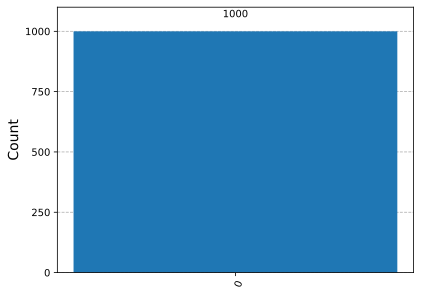

Statevector([ 0.5-0.j , -0.5+0.j ,  0. +0.5j, -0. -0.5j],
            dims=(2, 2))


In [89]:
# Delete the following
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit_aer import Aer, statevector_simulator
from qiskit.visualization import plot_histogram

q = QuantumRegister(2, "qreg")
c = ClassicalRegister(1, "creg")
qc = QuantumCircuit(q,c)

#Encode the state
qc.x(q[1])
#Apply Hadmard
qc.h(q[0])

#Apply the Phase Gate
qc.cp(theta = np.pi/2, control_qubit = q[0], target_qubit = q[1])

#Apply the Hadamard on the qubit - 1
qc.h(q[1])

#Apply the SWAP Gate
qc.swap(q[1], q[0])

#Apply the RZZ(theta = pi/2) gate
# qc.rzz(np.pi/2, q[1], q[0])

# #Apply again the SWAP Gate
# qc.swap(q[1], q[0])

# #Apply again Hadamard Gate to the qubit 1
# qc.h(q[1])
# #Apply again the controlled Phase gate
# qc.cp(theta = np.pi/2, control_qubit = q[0], target_qubit = q[1])

# #Apply Hadamard to the qubit 0
# qc.h(q[0])


# Measurements


display(qc.draw())

#Statevector simulator
backend = Aer.get_backend('statevector_simulator')
qc_ex = transpile(qc, backend)
job = backend.run(qc_ex, shots = 1000)
result = job.result()
outputstate = result.get_statevector(qc_ex, decimals=3)
counts = result.get_counts()

print(counts)
display(plot_histogram(counts))
print(outputstate)



In [48]:
#Encoding the state for '10'

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit_aer import Aer, statevector_simulator
from qiskit.visualization import plot_histogram

q = QuantumRegister(2, "qreg")
c = ClassicalRegister(1, "creg")
qc2 = QuantumCircuit(q,c)

#Encode the state
qc2.x(q[1])

qc2.measure_all()

display(qc2.draw())

backend = Aer.get_backend('statevector_simulator')
qc_ex2 = transpile(qc2, backend)
job = backend.run(qc_ex2, shots = 1000)
result = job.result()
outputstate = result.get_statevector(qc_ex2, decimals=3)
counts = result.get_counts()

print(counts)
# display(plot_histogram(counts))
print(outputstate)

░ ┌─┐   
qreg_0: ──────░─┤M├───
        ┌───┐ ░ └╥┘┌─┐
qreg_1: ┤ X ├─░──╫─┤M├
        └───┘ ░  ║ └╥┘
creg: 1/═════════╬══╬═
                 ║  ║ 
meas: 2/═════════╩══╩═
                 0  1

{'10 0': 1000}
Statevector([0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
            dims=(2, 2))


In [82]:
# Suppose we are directly doing the QFT (INBUILT METHOD)

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit_aer import Aer, statevector_simulator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT

# Encoding
q = QuantumRegister(2, "qreg")
c = ClassicalRegister(1, "creg")
qc3 = QuantumCircuit(q, c)

qc3.x(q[1])
#Apply QFT##
qft = QFT(num_qubits=2).to_gate()
qc3.append(qft, qargs=[0, 1])

#Apply RZZ gate
qc3.rzz(np.pi/2, q[1], q[0])


#qc3.measure_all()

display(qc3.draw())

backend = Aer.get_backend('statevector_simulator')
qc_ex3 = transpile(qc3, backend)
job = backend.run(qc_ex3, shots=1000)
result = job.result()
outputstate1= result.get_statevector(qc_ex3, decimals=3)
counts = result.get_counts()

print(counts)
# display(plot_histogram(counts))
print(np.transpose(outputstate1))


┌──────┐          
qreg_0: ─────┤0     ├─■────────
        ┌───┐│  QFT │ │ZZ(π/2) 
qreg_1: ┤ X ├┤1     ├─■────────
        └───┘└──────┘          
creg: 1/═══════════════════════

{'0': 1000}
[ 0.354-0.354j -0.354-0.354j  0.354+0.354j -0.354+0.354j]


In [75]:
#Encoding the state for '10'

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit_aer import Aer, statevector_simulator
from qiskit.visualization import plot_histogram

q = QuantumRegister(2, "qreg")
c = ClassicalRegister(1, "creg")
qc2 = QuantumCircuit(q,c)

#Encode the state
qc2.x(q[1])

#qc2.measure_all()

display(qc2.draw())

backend = Aer.get_backend('statevector_simulator')
qc_ex2 = transpile(qc2, backend)
job = backend.run(qc_ex2, shots = 1000)
result = job.result()#
outputstate = result.get_statevector(qc_ex2, decimals=3)
counts = result.get_counts()

print(counts)
# display(plot_histogram(counts))
print(outputstate)

qreg_0: ─────
        ┌───┐
qreg_1: ┤ X ├
        └───┘
creg: 1/═════

{'0': 1000}
Statevector([0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
            dims=(2, 2))


In [81]:
exp_val_qiskit = np.dot(np.transpose(outputstate), outputstate1)
print(exp_val_qiskit)

0j


In [61]:
#Getting the product

array = np.array([
    [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j]

])
array1 = np.transpose(array)
array2 = np.array([
    [ 0.   +0.j   , -0.707-0.707j,  0.   +0.j   , -0.   +0.j   ]

])

product_value = np.dot(array1, array2)

print(product_value)

[[ 0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j   ]
 [ 0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j   ]
 [ 0.   +0.j    -0.707-0.707j  0.   +0.j     0.   +0.j   ]
 [ 0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j   ]]


Using QUIMB

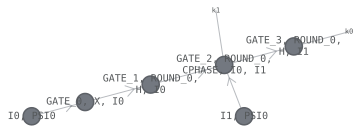

array([[ 0.5+0.j],
       [-0.5+0.j],
       [ 0.5+0.j],
       [-0.5+0.j]])

In [93]:
# def qft_rotations(circuit, qubits):
#     for i in range(len(qubits)):
#         circuit.apply_gate('H', qubits[i], 'contract', False)
#         for j in range(i+1, len(qubits)):
#             lamda = np.pi / 2**(j - i)
#             circuit.apply_gate('CPHASE', lamda, qubits[i], qubits[j])

from quimb.tensor.circuit import Circuit
num_qubits = 2
random_state = '10'
#Encoding the states

# #First let us create the circuit so that we can store the states in their particular order
# qc = qtn.Circuit(num_qubits)
# #Getting the registers
# regs = list(range(num_qubits))
# #Encoding the values
# for i, number in enumerate(random_state):
#   if number =='1':
#     qc.apply_gate('X', regs[i])
# # print(regs)

# qc.psi.draw()
# # Drawing the circuit
# # qc.psi.to_dense()
# depth = 1




def circ_qft(num_qubits, random_state, depth,
    **circuit_opts,
):

    circuit_opts.setdefault('gate_opts', {})
    circuit_opts['gate_opts'].setdefault('contract', False)

    n = num_qubits
    gates = []
    qubits=np.arange(n)
    for i, number in enumerate(random_state):
      if number == '1':
            gates.append(('X', qubits[i]))

    #QFT
    for d in range(depth):
        for i in range(num_qubits):
            gates.append((d, 'h', i)) #H gate
            for j in range(i+1, num_qubits):
                lamda = np.pi / 2
                gates.append((d, 'CPHASE', lamda, qubits[i], qubits[j]))#Cphase

        for k in range(num_qubits//2):
            gates.append((d, 'SWAP', qubits[k], qubits[len(qubits)-k-1]))






    circ = Circuit(n, **circuit_opts)
    circ.apply_gates(gates)


    return circ

# def circ_qft_reverse(num_qubits, random_state, depth,
#     **circuit_opts,
# ):

#     circuit_opts.setdefault('gate_opts', {})
#     circuit_opts['gate_opts'].setdefault('contract', False)

#     n = num_qubits
#     gates = []
#     qubits=np.arange(n)
#     for i, number in enumerate(random_state):
#             gates.append(('X', qubits[i]))

#     #QFT
#     for d in range(depth):
#         for i in range(num_qubits):
#             for i in range(num_qubits//2):
#                 gates.append((d, 'CNOT', qubits[i], qubits[len(qubits)-i-1]))
#                 gates.append((d, 'CNOT', qubits[len(qubits)-i-1], qubits[i]))
#                 gates.append((d, 'CNOT', qubits[i], qubits[len(qubits)-i-1]))

#             for j in range(i+1, num_qubits):
#                 lamda = np.pi / 2
#                 gates.append((d, 'CPHASE', lamda, qubits[i], qubits[j]))#Cphase


#             gates.append((d, 'h', i)) #H gate








#     circ = Circuit(n, **circuit_opts)
#     circ.apply_gates(gates)


    # return circ

qubits=np.arange(num_qubits)
# for i in range(num_qubits//2):
#    print(i, len(qubits)-i-1)

#Applying the QFT
n = num_qubits
qubits = np.arange(n)
qc= circ_qft(num_qubits, random_state, depth)


# qc.psi.draw()

#Applying the RZZ (theta = pi/2)

# qc.apply_gate('RZZ', np.pi/2, qubits[0], qubits[1])

qc.psi.draw()
# #Applying the reverse QFT
# qc = circ_qft_reverse(num_qubits, random_state, depth)

#Get the statevector

qc.psi.to_dense()





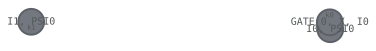

array([[0.+0.j],
       [0.+0.j],
       [1.+0.j],
       [0.+0.j]])

In [70]:
#Encode the basis state '10' and get the state vector
num_qubits = 2
random_state = '10'
qc_new = qtn.Circuit(num_qubits)
#Getting the registers
regs = list(range(num_qubits))
#Encoding the values
for i, number in enumerate(random_state):
  if number =='1':
    qc_new.apply_gate('X', regs[i])
# print(regs)

qc_new.psi.draw()
# Drawing the circuit
qc_new.psi.to_dense()

In [71]:
#Dot product to get the expectation value

array = np.array([
    [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j]

])
array1 = np.transpose(array1)
array2 = np.array([[0.        -2.29934717e-17j],
       [0.        +0.00000000e+00j],
       [0.70710678+7.07106781e-01j],
       [0.        +0.00000000e+00j]])

product_value = np.dot(array1, array2)

print(product_value)

[[0.70710678+0.70710678j]]
